--- Starting VERBOSE Training for GENERAL Models ---
✅ Filtered non-toddler data. Remaining instances: 5021

--- Tuning Logistic Regression for general population ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'C': 0.1}

Classification Report on Test Set:
              precision    recall  f1-score   support

          NO       1.00      1.00      1.00       644
         YES       1.00      1.00      1.00       361

    accuracy                           1.00      1005
   macro avg       1.00      1.00      1.00      1005
weighted avg       1.00      1.00      1.00      1005



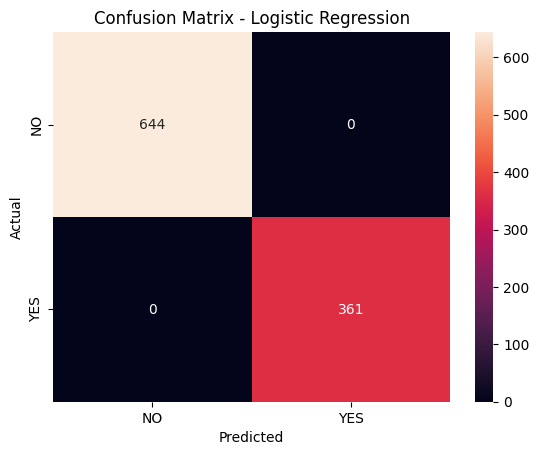


--- Tuning AdaBoost for general population ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'n_estimators': 50}

Classification Report on Test Set:
              precision    recall  f1-score   support

          NO       1.00      1.00      1.00       644
         YES       1.00      1.00      1.00       361

    accuracy                           1.00      1005
   macro avg       1.00      1.00      1.00      1005
weighted avg       1.00      1.00      1.00      1005



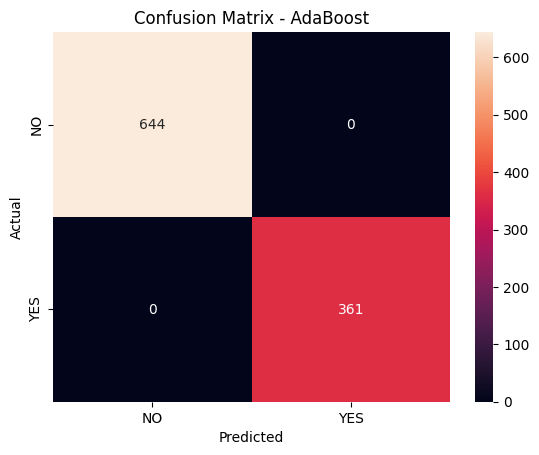


--- Tuning XGBoost for general population ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\hardi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:36:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'n_estimators': 200}

Classification Report on Test Set:
              precision    recall  f1-score   support

          NO       1.00      0.99      1.00       644
         YES       0.99      1.00      0.99       361

    accuracy                           1.00      1005
   macro avg       0.99      1.00      1.00      1005
weighted avg       1.00      1.00      1.00      1005



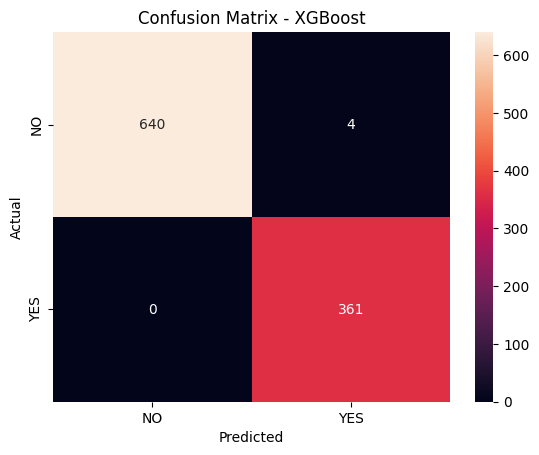


Full Model Performance Ranking (sorted by Recall):


,Model,Recall (YES),Precision (YES),Accuracy
0,Logistic Regression,1.0,1.000000,1.00000
1,AdaBoost,1.0,1.000000,1.00000
2,XGBoost,1.0,0.989041,0.99602



--- Saving Top 3 General Models ---
✅ Saved Rank 1: Logistic Regression with Recall: 1.0000
✅ Saved Rank 2: AdaBoost with Recall: 1.0000
✅ Saved Rank 3: XGBoost with Recall: 1.0000
✅ General artifacts saved to 'models/general' directory.


In [7]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Import All 9 Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def train_general_models_verbose():
    """
    Trains, tunes, and evaluates all 9 models on the general (non-toddler) dataset
    with detailed step-by-step output, then saves the top 3.
    """
    print("=" * 60)
    print("--- Starting VERBOSE Training for GENERAL Models ---")
    print("=" * 60)

    # --- Stage 1: Data Loading, Cleaning, and Filtering ---
    df = pd.read_csv(".\datasets\Autism_Screening_Data_Combined.csv", na_values=["?"])

    column_mapping = {
        "A1": "A1_Score",
        "A2": "A2_Score",
        "A3": "A3_Score",
        "A4": "A4_Score",
        "A5": "A5_Score",
        "A6": "A6_Score",
        "A7": "A7_Score",
        "A8": "A8_Score",
        "A9": "A9_Score",
        "A10": "A10_Score",
        "Sex": "Gender",
        "Jauundice": "Jaundice",
        "Family_ASD": "Family_History_ASD",
        "Class": "Class/ASD",
    }
    df.rename(columns=column_mapping, inplace=True)
    df["Age"] = pd.to_numeric(df["Age"], errors="coerce").fillna(df["Age"].median())

    if "Ethnicity" in df.columns:
        df = df.drop(columns=["Ethnicity"])

    df = df[df["Age"] >= 4].reset_index(drop=True)
    print(f"✅ Filtered non-toddler data. Remaining instances: {len(df)}")

    # --- Stage 2: Preprocessing ---
    X = df.drop("Class/ASD", axis=1)
    y = df["Class/ASD"]
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    preprocessors = {"imputers": {}, "encoders": {}, "scaler": MinMaxScaler()}
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

    # Process Numerical Columns
    num_imputer = SimpleImputer(strategy="median")
    X_train.loc[:, numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
    X_test.loc[:, numerical_cols] = num_imputer.transform(X_test[numerical_cols])
    preprocessors["imputers"]["numerical"] = num_imputer

    # Process Categorical Columns
    for col in categorical_cols:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        X_train.loc[:, col] = cat_imputer.fit_transform(X_train[[col]]).ravel()
        X_test.loc[:, col] = cat_imputer.transform(X_test[[col]]).ravel()
        preprocessors["imputers"][col] = cat_imputer

        le = LabelEncoder()
        X_train.loc[:, col] = le.fit_transform(X_train[col])
        X_test.loc[:, col] = le.transform(X_test[col])
        preprocessors["encoders"][col] = le

        X_train[col] = X_train[col].astype(int)
        X_test[col] = X_test[col].astype(int)

    # --- THE FIX TO REMOVE WARNINGS ---
    # Explicitly cast numerical columns to float before scaling.
    for col in numerical_cols:
        X_train[col] = X_train[col].astype(float)
        X_test[col] = X_test[col].astype(float)

    # Scale Numerical Columns
    scaler = MinMaxScaler()
    X_train.loc[:, numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test.loc[:, numerical_cols] = scaler.transform(X_test[numerical_cols])
    preprocessors["scaler"] = scaler

    # Balance Data with SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled_np, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Reconstruct DataFrame to fix dtypes for XGBoost
    X_train_resampled = pd.DataFrame(X_train_resampled_np, columns=X_train.columns)
    X_train_resampled = X_train_resampled.astype(X_train.dtypes.to_dict())

    preprocessors["feature_order"] = X_train.columns.tolist()

    # --- Stage 3: Train and Evaluate All 9 Models ---
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        # "K-Nearest Neighbors": KNeighborsClassifier(),
        # "Decision Tree": DecisionTreeClassifier(random_state=42),
        # "Gaussian Naive Bayes": GaussianNB(),
        # "SVM": SVC(probability=True, random_state=42),
        # "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        # "Random Forest": RandomForestClassifier(random_state=42),
        "AdaBoost": AdaBoostClassifier(random_state=42),
        "XGBoost": xgb.XGBClassifier(
            use_label_encoder=False, eval_metric="logloss", random_state=42
        ),
    }
    params = {
        "Logistic Regression": {"C": [0.1, 1, 10]},
        # "K-Nearest Neighbors": {"n_neighbors": [3, 5, 7]},
        # "Decision Tree": {"max_depth": [5, 10, None]},
        # "Gaussian Naive Bayes": {},
        # "SVM": {"C": [0.1, 1], "kernel": ["linear", "rbf"]},
        # "Linear Discriminant Analysis": {},
        # "Random Forest": {"n_estimators": [100, 200]},
        "AdaBoost": {"n_estimators": [50, 100]},
        "XGBoost": {"n_estimators": [100, 200]},
    }

    results = []
    trained_models = {}
    for name, model in models.items():
        print(f"\n--- Tuning {name} for general population ---")
        grid_search = GridSearchCV(
            model, params[name], cv=3, scoring="recall", n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        print(f"Best Parameters: {grid_search.best_params_}")
        print("\nClassification Report on Test Set:")
        print(
            classification_report(y_test, y_pred, target_names=target_encoder.classes_)
        )

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
        )
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        report = classification_report(
            y_test, y_pred, output_dict=True, target_names=target_encoder.classes_
        )
        results.append(
            {
                "Model": name,
                "Recall (YES)": report["YES"]["recall"],
                "Precision (YES)": report["YES"]["precision"],
                "Accuracy": report["accuracy"],
            }
        )
        trained_models[name] = best_model

    # --- Stage 4: Compare Models and Save Top 3 ---
    results_df = pd.DataFrame(results).sort_values(by="Recall (YES)", ascending=False)

    print("\nFull Model Performance Ranking (sorted by Recall):")
    display(results_df)

    top_3_models = results_df.head(3)

    output_dir = "models/general"
    os.makedirs(output_dir, exist_ok=True)

    print("\n--- Saving Top 3 General Models ---")
    for index, row in top_3_models.iterrows():
        rank = results_df.index.get_loc(index) + 1
        model_name = row["Model"]
        model_object = trained_models[model_name]
        filename = f"general_model_rank_{rank}_{model_name.replace(' ', '_')}.joblib"
        joblib.dump(model_object, os.path.join(output_dir, filename))
        print(
            f"✅ Saved Rank {rank}: {model_name} with Recall: {row['Recall (YES)']:.4f}"
        )

    joblib.dump(
        {"preprocessors": preprocessors, "target_encoder": target_encoder},
        os.path.join(output_dir, "general_artifacts.joblib"),
    )
    print(f"✅ General artifacts saved to '{output_dir}' directory.")


if __name__ == "__main__":
    train_general_models_verbose()